In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(tidyverse)
    library(ComplexHeatmap)
    library(logger)
})

# Read Data

In [2]:
intSiteHBV <- readr::read_tsv("./data/HBV_intSites.tsv", guess_max = 1000, 
                              col_types = cols(siteHuman = col_character(),representSites = col_character()))
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_tumor_D1220.rds")

In [3]:
intSiteHBV <- intSiteHBV[intSiteHBV$representSites == '9:26713423',]
colData(sce)[intSiteHBV$cell.id, 'HBVintSite'] <- intSiteHBV$representSites

In [4]:
sce$HBVintSite <- ifelse(is.na(sce$HBVintSite), "None", "HBVintSite")

In [76]:
fisher.test(table( sce$leiden, sce$HBVintSite))


	Fisher's Exact Test for Count Data

data:  table(sce$leiden, sce$HBVintSite)
p-value = 0.00938
alternative hypothesis: two.sided


            
              0  1  2
  HBVintSite 48 36  6
  None       27 25 16

Warning message:
“'multiplot' is deprecated.
Use 'gridExtra::grid.arrange' instead.
See help("Deprecated")”


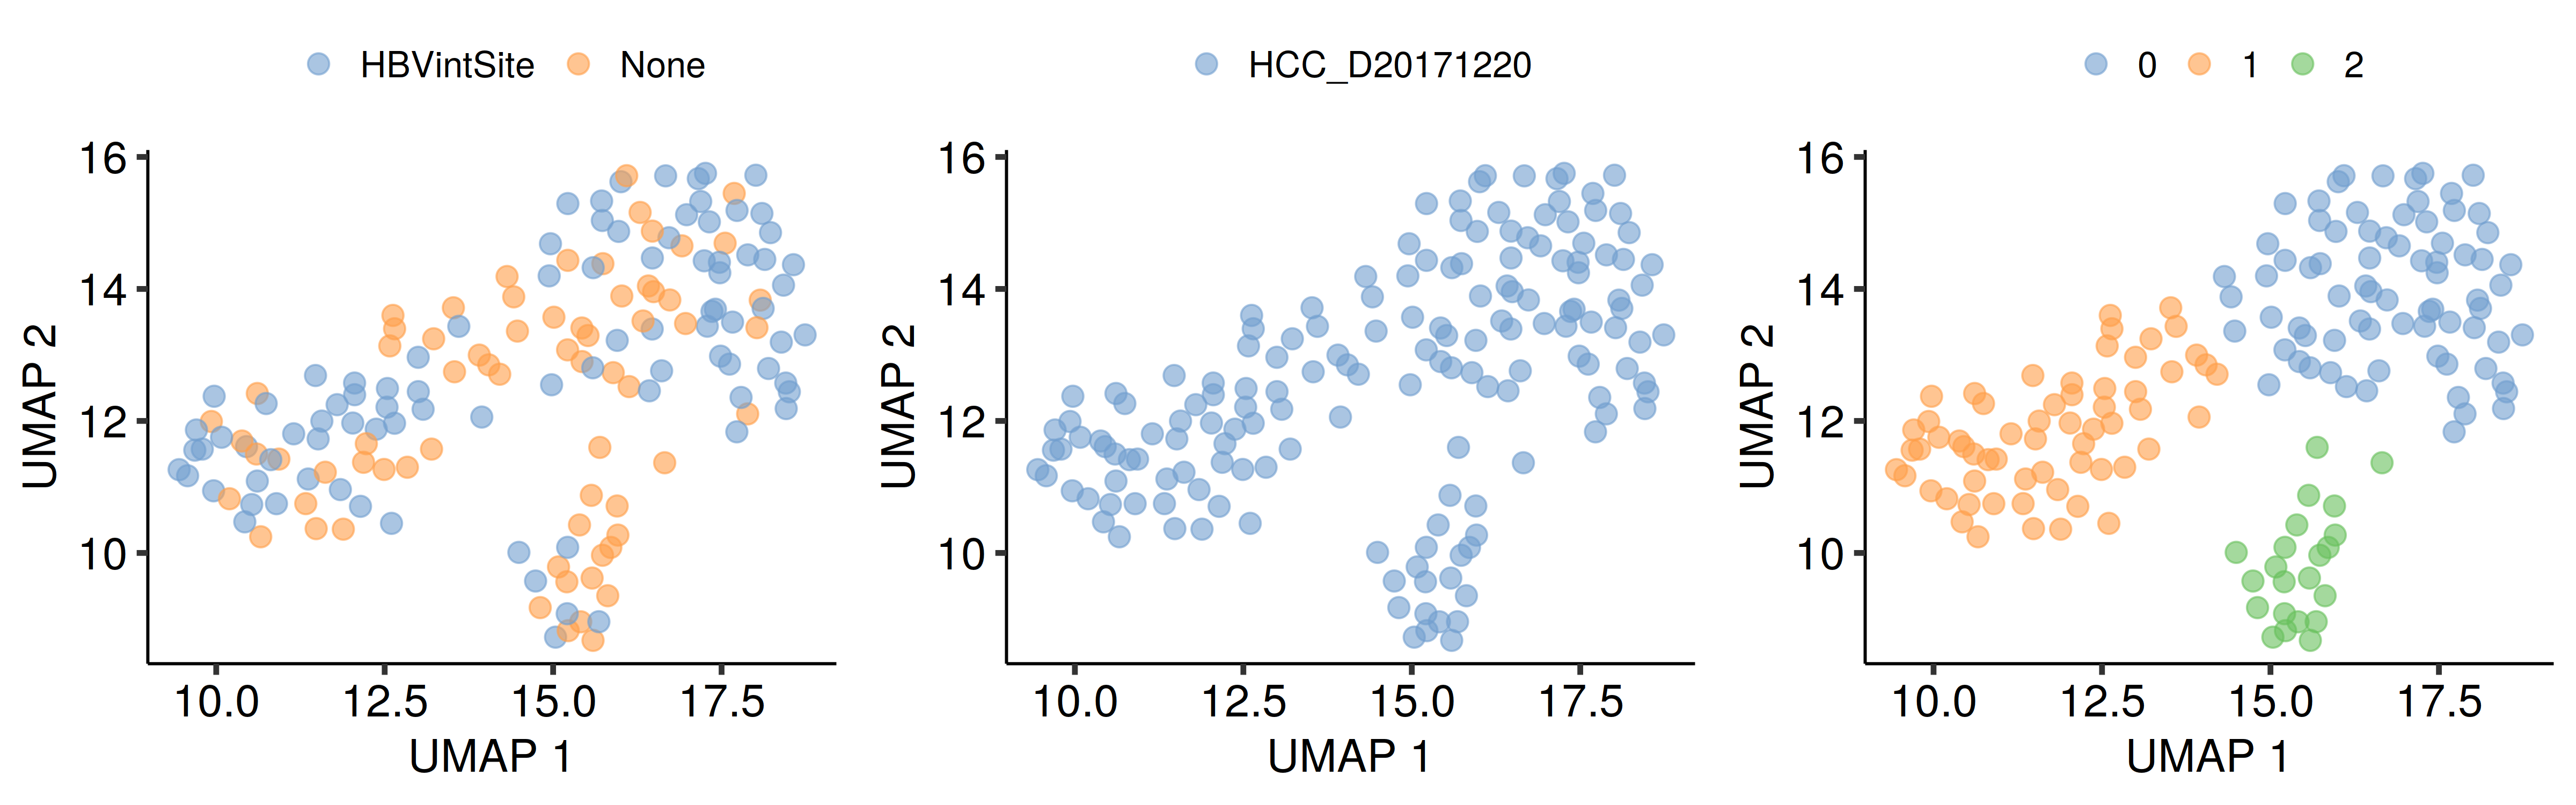

In [6]:
options(repr.plot.width = 16, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = "HBVintSite", point_size = 4) + ggpubr::theme_pubr(base_size = 20) + theme(legend.title = element_blank())
p2 <- plotUMAP(sce, colour_by = "celltype", point_size = 4) + guides(fill = guide_legend(ncol = 2)) +ggpubr::theme_pubr(base_size = 20) + theme(legend.title = element_blank())
p3 <- plotUMAP(sce, colour_by = "leiden", point_size = 4) + ggpubr::theme_pubr(base_size = 20) + theme(legend.title = element_blank())
multiplot(p1, p2, p3, cols = 3)

In [21]:
plotDF <- makePerCellDF(sce, features = c("CAAP1", "IFT74", "PLAA", "TEK", "EQTN", "LINGO2", "MOB3B", "C9orf72"), use_dimred = F)

In [22]:
plotDF <- plotDF %>% 
    tidyr::pivot_longer(cols =  c("CAAP1", "IFT74", "PLAA", "TEK", "EQTN", "LINGO2", "MOB3B", "C9orf72"), names_to = "gene", values_to = "expr") %>% 
    mutate(gene = factor(gene, levels = c("CAAP1", "IFT74", "PLAA", "TEK", "EQTN", "LINGO2", "MOB3B", "C9orf72"))) 
    

In [23]:
head(plotDF)

cell.id,cell.type,tissue,facs,donor,isHBV,isHCV,histology,ExonicReads,ExonicReadsPer,⋯,Sample,sizeFactor,leiden_global,leiden_global_celltype,leiden_sub,celltype_old,leiden_sublevel1,HBVintSite,gene,expr
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
TP5-10-20171220,TP5,Tumor,CD45-,D20171220,HBV+,HCV-,HCC,622888,0.7903,⋯,D20171220_Tumor,1.093691,Global_C23,Hepatocytes,C09,Malignant_EPCAM_D1220,C01,None,CAAP1,0.0000000
TP5-10-20171220,TP5,Tumor,CD45-,D20171220,HBV+,HCV-,HCC,622888,0.7903,⋯,D20171220_Tumor,1.093691,Global_C23,Hepatocytes,C09,Malignant_EPCAM_D1220,C01,None,IFT74,3.5815943
TP5-10-20171220,TP5,Tumor,CD45-,D20171220,HBV+,HCV-,HCC,622888,0.7903,⋯,D20171220_Tumor,1.093691,Global_C23,Hepatocytes,C09,Malignant_EPCAM_D1220,C01,None,PLAA,7.7478863
TP5-10-20171220,TP5,Tumor,CD45-,D20171220,HBV+,HCV-,HCC,622888,0.7903,⋯,D20171220_Tumor,1.093691,Global_C23,Hepatocytes,C09,Malignant_EPCAM_D1220,C01,None,TEK,0.9368431
TP5-10-20171220,TP5,Tumor,CD45-,D20171220,HBV+,HCV-,HCC,622888,0.7903,⋯,D20171220_Tumor,1.093691,Global_C23,Hepatocytes,C09,Malignant_EPCAM_D1220,C01,None,EQTN,0.0000000
TP5-10-20171220,TP5,Tumor,CD45-,D20171220,HBV+,HCV-,HCC,622888,0.7903,⋯,D20171220_Tumor,1.093691,Global_C23,Hepatocytes,C09,Malignant_EPCAM_D1220,C01,None,LINGO2,0.0000000


In [24]:
meanDF <- plotDF %>% group_by(HBVintSite, gene) %>% summarise(mean_expr = mean(expr))

`summarise()` regrouping output by 'HBVintSite' (override with `.groups` argument)



In [ ]:
plotDF 

Joining, by = c("HBVintSite", "gene")



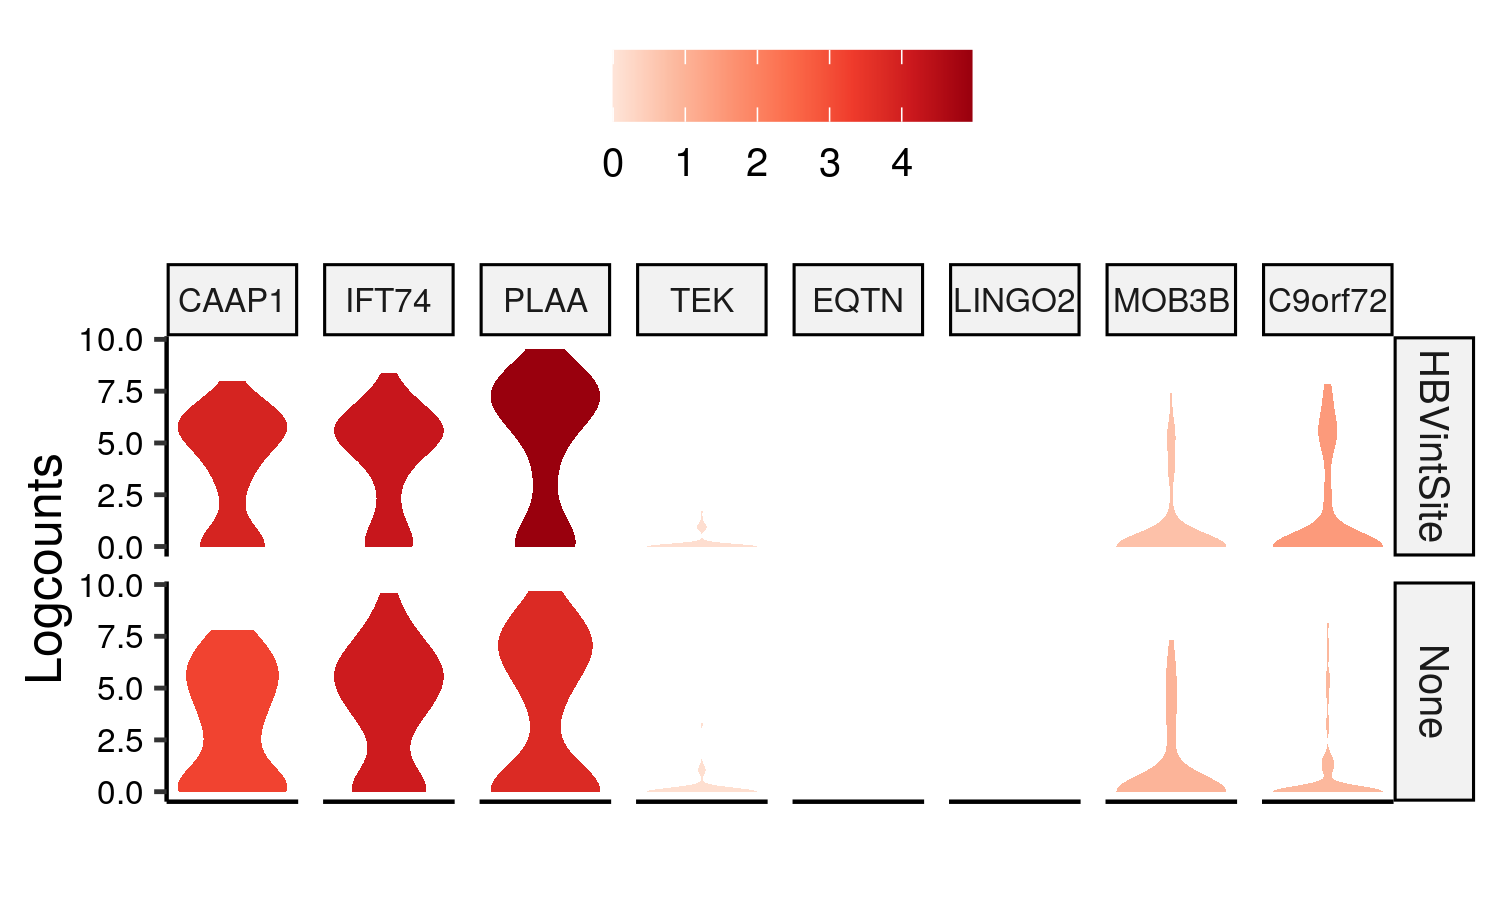

In [57]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

plotDF %>%
    left_join(meanDF) %>%
    ggplot(aes( x = gene, y = expr)) +
        geom_violin(aes(fill = mean_expr), color = NA, width = 1) + 
        #ggbeeswarm::geom_quasirandom(aes(color = mean_expr)) +
        facet_grid(HBVintSite ~ gene, scales = "free_x") +
        scale_fill_distiller(palette = "Reds", direction = 1) +
        scale_color_distiller(palette = "Reds", direction = 1) +
        ggpubr::theme_pubr() + ylab("Logcounts") + theme(axis.text.x = element_blank(), strip.text.x = element_text(size = 8), axis.ticks.x = element_blank(),axis.text.y = element_text(size = 8), legend.title = element_blank()) + xlab("")

Warning message:
“'multiplot' is deprecated.
Use 'gridExtra::grid.arrange' instead.
See help("Deprecated")”


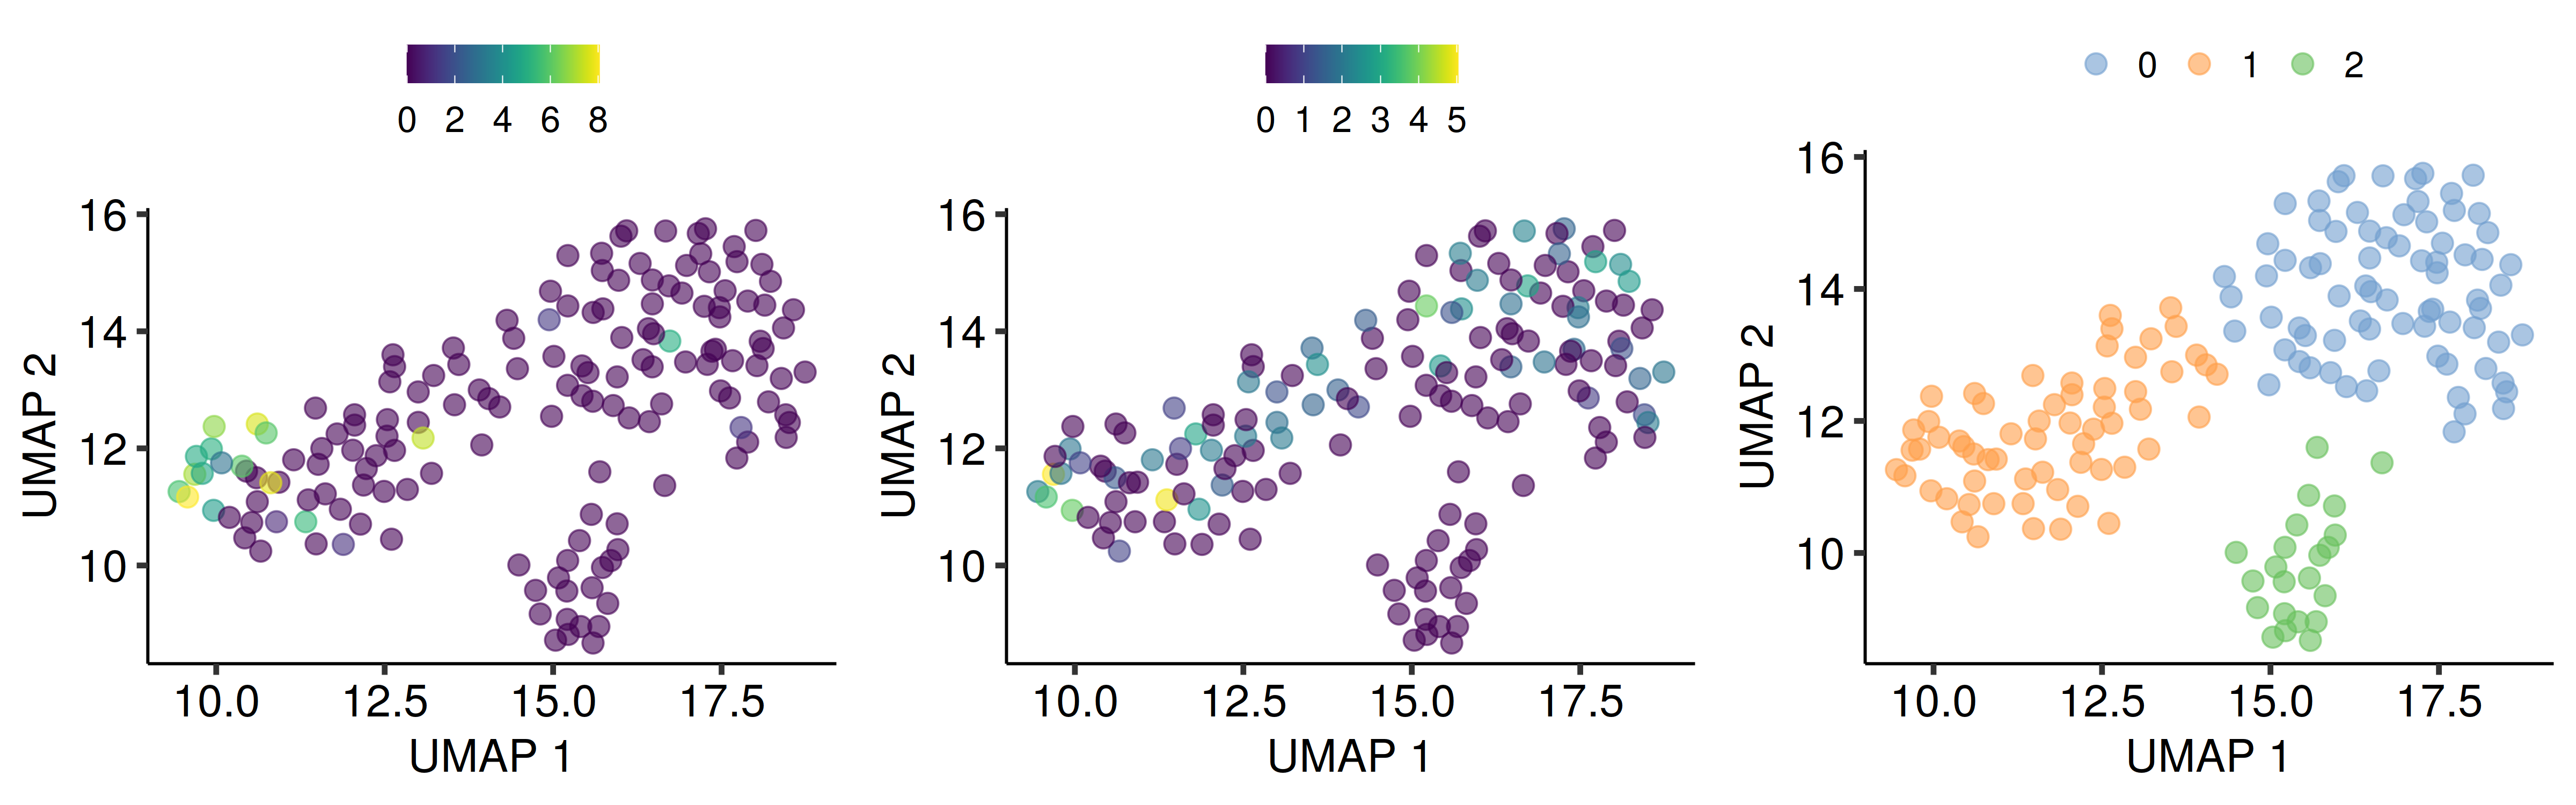

In [8]:
options(repr.plot.width = 16, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = "CD274", point_size = 4) + ggpubr::theme_pubr(base_size = 20) + theme(legend.title = element_blank())
p2 <- plotUMAP(sce, colour_by = "HAVCR2", point_size = 4)  +ggpubr::theme_pubr(base_size = 20) + theme(legend.title = element_blank())
p3 <- plotUMAP(sce, colour_by = "leiden", point_size = 4) + ggpubr::theme_pubr(base_size = 20) + theme(legend.title = element_blank())
multiplot(p1, p2, p3, cols = 3)

# Differential Expression between sites and HBVexpressed

## Limma

In [26]:
library(limma)
dge <- convertTo(sce)
design <- model.matrix(~0 + HBVintSite + leiden, dge$samples)
dge <- dge[calculateAverage(dge$counts) > 0.1,]
v <- voom(dge, design)
fit <- lmFit(v, design)
fit <- eBayes(fit)
contrasts <- makeContrasts(HBVintSiteHBVintSite-HBVintSiteNone, levels=design)
fit2 <- contrasts.fit(fit, contrasts)
fit2 <- eBayes(fit2)
res <- topTable(fit2, n=Inf, sort.by="none")
res$Chr <- NULL
res$Start <- NULL
res$End <- NULL
res$Strand <- NULL


Attaching package: ‘limma’


The following object is masked from ‘package:scater’:

    plotMDS


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [29]:
topDE <- res[res$adj.P.Val < 0.1  & res$Biotype == 'protein_coding',]

In [30]:
topDE

,Geneid,Length,Symbol,Biotype,highly_variable,varm.PCs.1,varm.PCs.2,varm.PCs.3,varm.PCs.4,varm.PCs.5,⋯,varm.PCs.47,varm.PCs.48,varm.PCs.49,varm.PCs.50,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C4BPA,ENSG00000123838.9,2441,C4BPA,protein_coding,TRUE,-0.013204763,-0.006254909,-0.04685685,0.01161054,0.003672508,⋯,0.012169939,0.003518503,0.02007465,0.004422653,0.7459865,7.749225,4.693756,5.445527e-06,0.01969881,3.485785
SP140L,ENSG00000185404.15,5650,SP140L,protein_coding,TRUE,0.003762756,-0.026037390,-0.01864806,0.01459894,-0.005872735,⋯,0.006340116,0.009948697,-0.01329941,0.019803452,0.7314459,4.596804,4.696965,5.370272e-06,0.01969881,3.482806
BTN3A1,ENSG00000026950.15,5547,BTN3A1,protein_coding,TRUE,0.004686338,-0.030084001,-0.03920816,0.05698082,-0.010133110,⋯,0.009344758,-0.001550926,0.01674895,0.027705339,1.0402174,4.891456,4.865557,2.561508e-06,0.01624850,3.853911
CLDN5,ENSG00000184113.9,3429,CLDN5,protein_coding,FALSE,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,⋯,0.000000000,0.000000000,0.00000000,0.000000000,0.6998505,4.279088,4.663351,6.210871e-06,0.01969881,3.343171


In [145]:
table(rownames(sce) == "SERPINA3")


FALSE 
60682 

In [179]:
head(res)

,Geneid,Length,Symbol,Biotype,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WASH7P_ENSG00000227232,ENSG00000227232.5,1351,WASH7P,unprocessed_pseudogene,0.1229297,0.5599631,0.5247943,0.6004282,0.8262822,-5.729654
MIR6859-3,ENSG00000278267.1,68,MIR6859-3,miRNA,0.1011236,-1.0989960,0.9755784,0.3306967,0.6645878,-6.330700
RP11-34P13.16,ENSG00000269981.1,284,RP11-34P13.16,processed_pseudogene,0.1843060,-0.8204122,1.1175083,0.2653961,0.6143176,-6.021628
RP11-34P13.14,ENSG00000239906.1,323,RP11-34P13.14,antisense,0.1386268,-1.0782305,1.1787755,0.2401789,0.5962414,-6.106753
RP11-34P13.13,ENSG00000241860.5,6195,RP11-34P13.13,processed_transcript,-0.3471449,-0.6123504,-1.6559308,0.0996300,0.4386706,-5.150169
FO538757.2,ENSG00000279457.2,1982,FO538757.2,protein_coding,0.0606324,0.6808207,0.2295738,0.8187063,0.9299390,-5.785668


## Gprofiler

In [160]:
library(gprofiler2)
gostres <- gost(query = rownames(topDE),
                organism = "hsapiens", ordered_query = FALSE, 
                multi_query = FALSE, significant = TRUE, exclude_iea = FALSE, 
                measure_underrepresentation = FALSE, evcodes = TRUE, 
                user_threshold = 0.05, correction_method = "g_SCS", 
                domain_scope = "annotated", custom_bg = NULL, 
                numeric_ns = "", sources = c("GO:BP", "REACTOME"), as_short_link = FALSE)

In [161]:

gem <- gostres$result[,c("term_id", "term_name", "p_value", "intersection")]

In [171]:
ggsci::pal_aaas()(8)

[1] "#3B4992FF" "#EE0000FF" "#008B45FF" "#631879FF" "#008280FF" "#BB0021FF"
[7] "#5F559BFF" "#A20056FF"

In [178]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)
p1 <- ggplot(gem, aes(x = reorder(term_name, -p_value), y = -log10(p_value))) +
    geom_bar(stat = 'identity', fill = '#3B4992FF') + 
    coord_flip() +  xlab("") +
    ggpubr::theme_pubr()

ggsave(p1, filename = "../05_figures/figures/Figure2Fright_HBV_signatures_GO.pdf", height = 2, width = 8)

## Vocalno Plot

In [186]:
genes <- unique(Reduce(union, strsplit(gem$intersection, ",")))

In [201]:
plotDF <- res
plotDF$FDR <- plotDF$adj.P.Val
#plotDF$logFC <- plotDF$logFC.None
plotDF$status <- 'NotSig'
plotDF[which(plotDF$FDR < 0.1 & plotDF$logFC > 1), 'status'] <- 'Up'
plotDF[which(plotDF$FDR < 0.1 & plotDF$logFC < -1), 'status'] <- 'Down'

In [202]:
labelDF <- plotDF[plotDF$Symbol %in% genes,]

In [210]:
p1 <- ggplot(plotDF, aes(x = logFC, y = -log10(adj.P.Val))) +
    geom_point(aes(fill = status), shape = 21, color = 'lightgrey', size = 2, alpha = .6) + 
    geom_hline(aes(yintercept = -log10(0.1)), linetype = 2, color = 'red' ) +
    ggrepel::geom_text_repel(data = labelDF, aes(label = Symbol)) +
    
    scale_fill_manual(values = c("NotSig" = "lightgrey", "Up" = 'red', "Down" = "blue")) +
    xlim(c(-3, 3)) + ylim(0, 5) + theme_bw(base_size = 20) + xlab("Log Fold Change") + ylab("-log10(FDR)")
ggsave(p1, filename = "../05_figures/figures/Figure2Fleft_HBV_signatures_vocalno_with_GOgenes.pdf", height = 5, width = 7)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


In [142]:
openxlsx::write.xlsx(topDE, file = "HBVpos_signatures_limma.xlsx")

# SCRAN markers

In [69]:
sub <- sce[,sce$leiden == 1]

In [70]:
keep1 <- rowData(sub)$Biotype == "protein_coding"
#keep2 <- calculateAverage(s) > 1

markers <- findMarkers(sub, groups = sub$HBVintSite,  subset.row = keep1 )
top_markers <- lapply(markers, function(df) { 
    df <- df[df$Top <= 20 & df$summary.logFC > 1,]
    df <- cbind(gene = rownames(df), df)
    df
})

In [71]:
topDE <- markers$HBVintSite

In [72]:
topDE <- as.data.frame(topDE[topDE$FDR < 0.05,])

In [73]:
topDE

Top,p.value,FDR,summary.logFC,logFC.None
<int>,<dbl>,<dbl>,<dbl>,<dbl>


In [68]:
topDE

,Top,p.value,FDR,summary.logFC,logFC.None
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
SULT2A1,1,2.679970e-06,0.03461702,3.210496,3.210496
ZC3H7A,2,3.494198e-06,0.03461702,2.890190,2.890190


In [57]:
openxlsx::write.xlsx(topDE, file = "markes_HBVpos.xlsx")

In [20]:
df <- sumCountsAcrossCells(sce,ids = sce$HBVintSite, average = T, assay.type = 'logcounts')

In [48]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)
plotDF <- as.data.frame(assay(df))


In [49]:
plotLabelDF <- plotDF[rownames(topDE), ]


In [37]:
plotDF

ERROR: Error in eval(expr, envir, enclos): object 'plotDF' not found


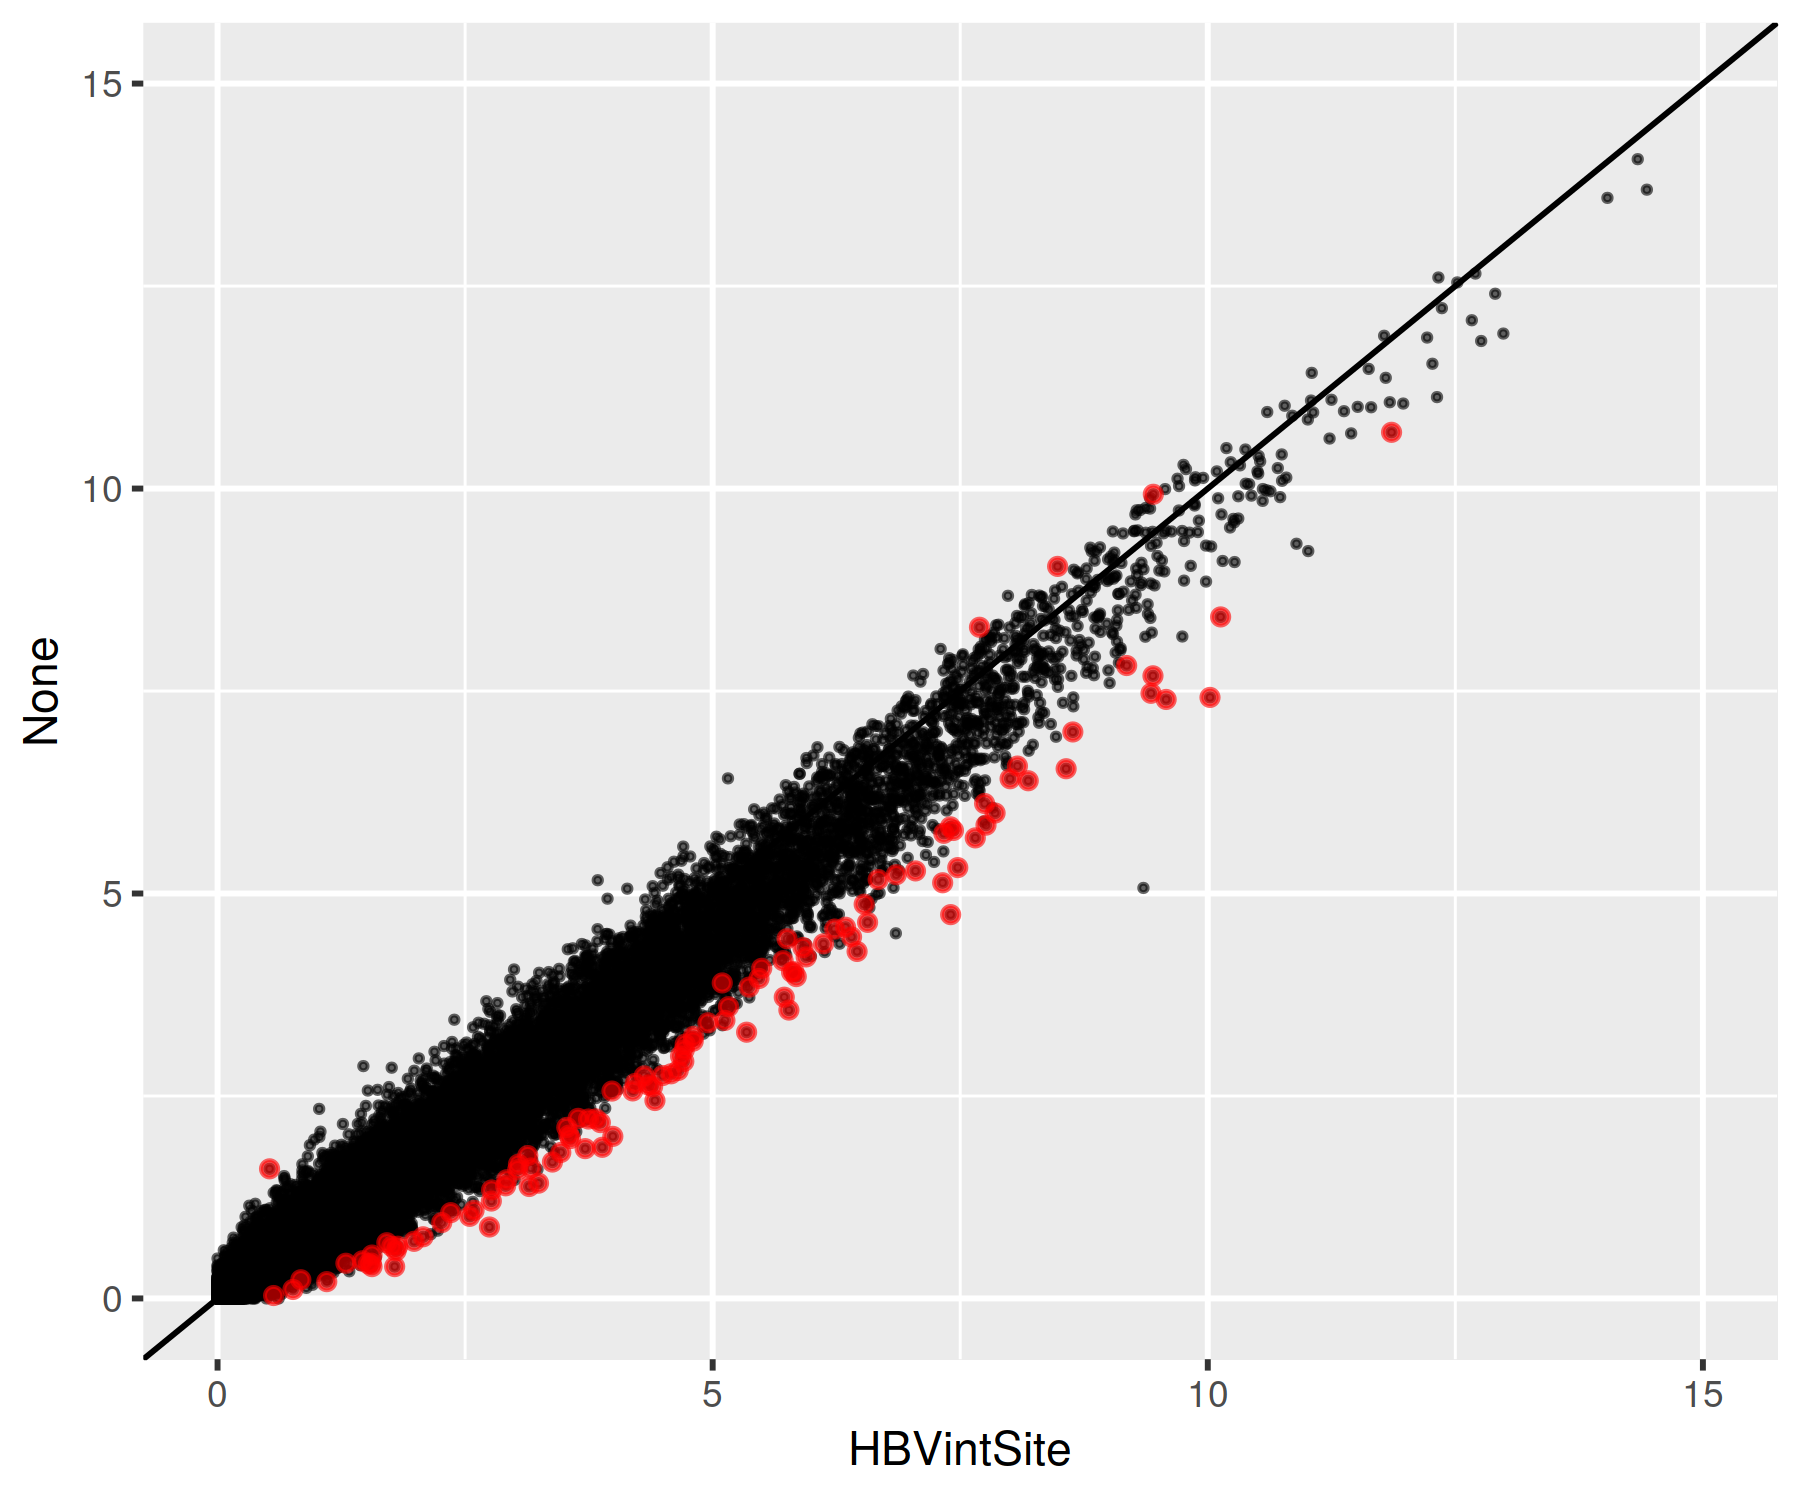

In [50]:
ggplot(as.data.frame(assay(df)), aes( x = HBVintSite, y = None)) +
    geom_point(alpha = .6, size = .5) +
    geom_point(data = plotLabelDF, color = 'red', alpha = .6) +

    geom_abline() +
    xlim(c(0, 15)) + ylim(c(0,15))

In [13]:
df <- markers$HBVintSite
df[df$FDR < 0.1,]

DataFrame with 41 rows and 5 columns
                 Top     p.value        FDR summary.logFC logFC.None
           <integer>   <numeric>  <numeric>     <numeric>  <numeric>
C4BPA              1 2.47015e-07 0.00489436       2.60141    2.60141
AZGP1              2 3.61344e-06 0.03579832       2.66427    2.66427
AQP11              3 7.19997e-06 0.04344579       1.86335    1.86335
C16orf13           4 1.04486e-05 0.04344579       1.83678    1.83678
GPRC5C             5 1.09634e-05 0.04344579       2.17400    2.17400
...              ...         ...        ...           ...        ...
VMP1              37 0.000175437  0.0939489       1.79477    1.79477
NUB1              38 0.000184834  0.0950776       1.87006    1.87006
RANBP9            39 0.000187142  0.0950776       1.45479    1.45479
UBE2F-SCLY        40 0.000197541  0.0978521       1.52392    1.52392
PPP1R10           41 0.000203840  0.0985092       1.68291    1.68291

In [103]:
df <- markers$HBVintSite
plotDF <- cbind(gene = rownames(markers$HBVintSite), as.data.frame(markers$HBVintSite))
plotDF$logFDR <- -log10(plotDF$FDR)
plotDF$logFC <- plotDF$logFC.None
plotDF$status <- 'NotSig'
plotDF[which(plotDF$FDR < 0.1 & plotDF$logFC > 1), 'status'] <- 'Up'
plotDF[which(plotDF$FDR < 0.1 & plotDF$logFC > -1), 'status'] <- 'Down'
labelDF <- plotDF[plotDF$FDR < 0.1 & plotDF$summary.logFC > 1, ]

In [106]:
table(sce$HBVintSite, sce$leiden_sublevel1)

            
             C00 C01 C02 C03 C04 C05 C06
  HBVintSite  22  18   6  10   9  10  15
  None        10   8  19  11  10   9   1

In [100]:
openxlsx::write.xlsx(labelDF, file = "HBVpos_signatures.xlsx")

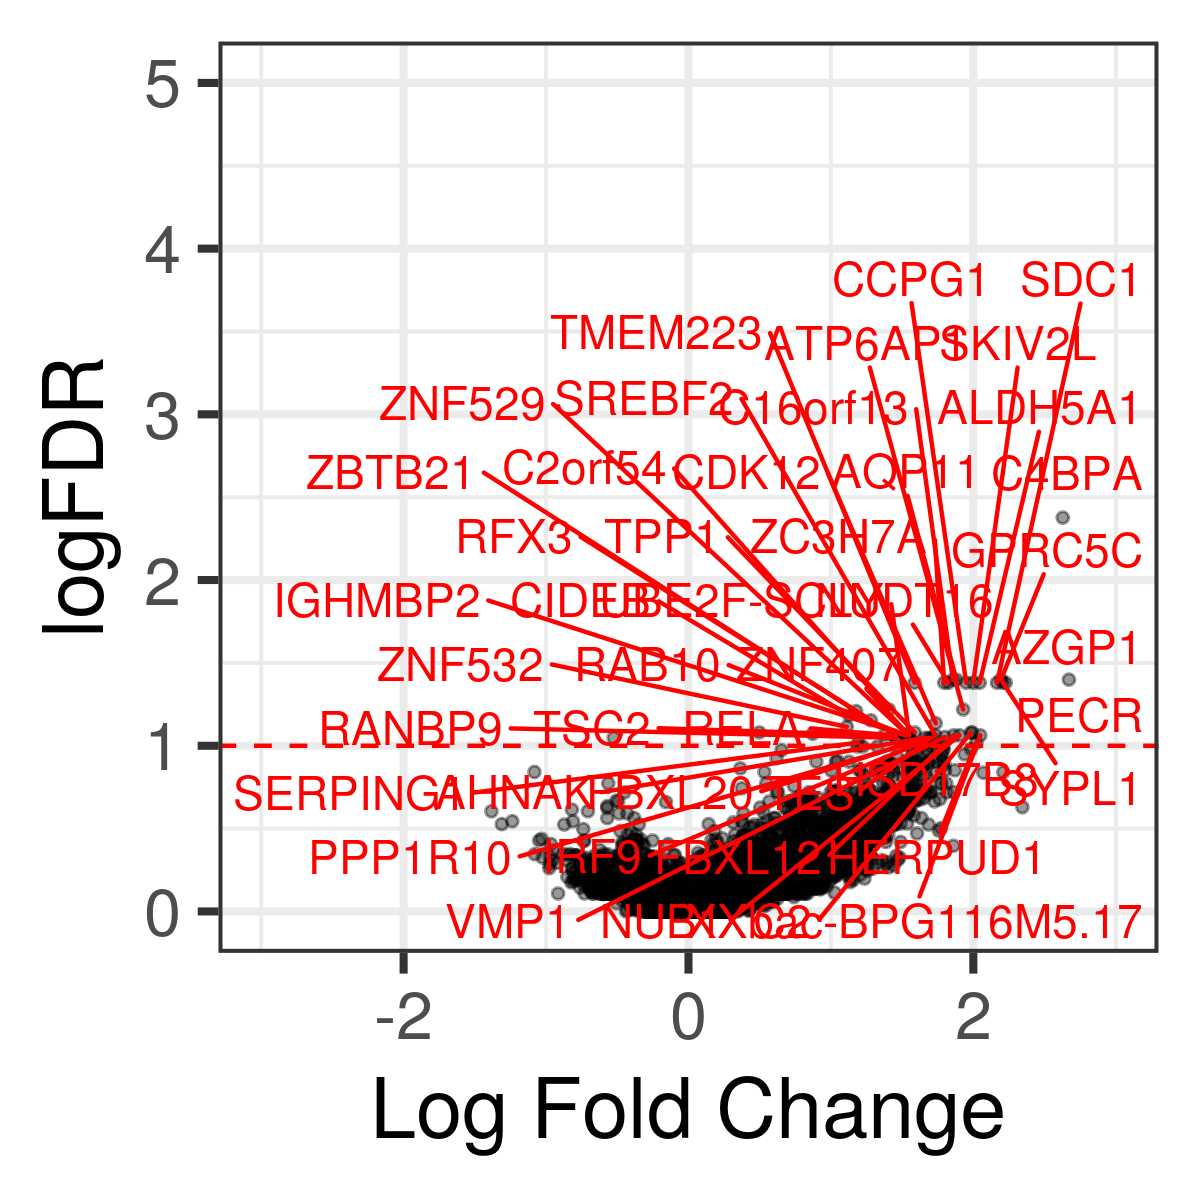

In [104]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
ggplot(plotDF, aes(x = logFC, y = logFDR)) +
        geom_point(size = 1, alpha = .4) + 
        ggrepel::geom_text_repel(data = labelDF, aes(label = gene), color = 'red') +
        geom_hline(aes(yintercept = -log10(0.1)), linetype = 2, color = 'red' ) +
        xlim(c(-3, 3)) + ylim(0, 5) + theme_bw(base_size = 20) + xlab("Log Fold Change")

In [ ]:
sce$HBVintSite

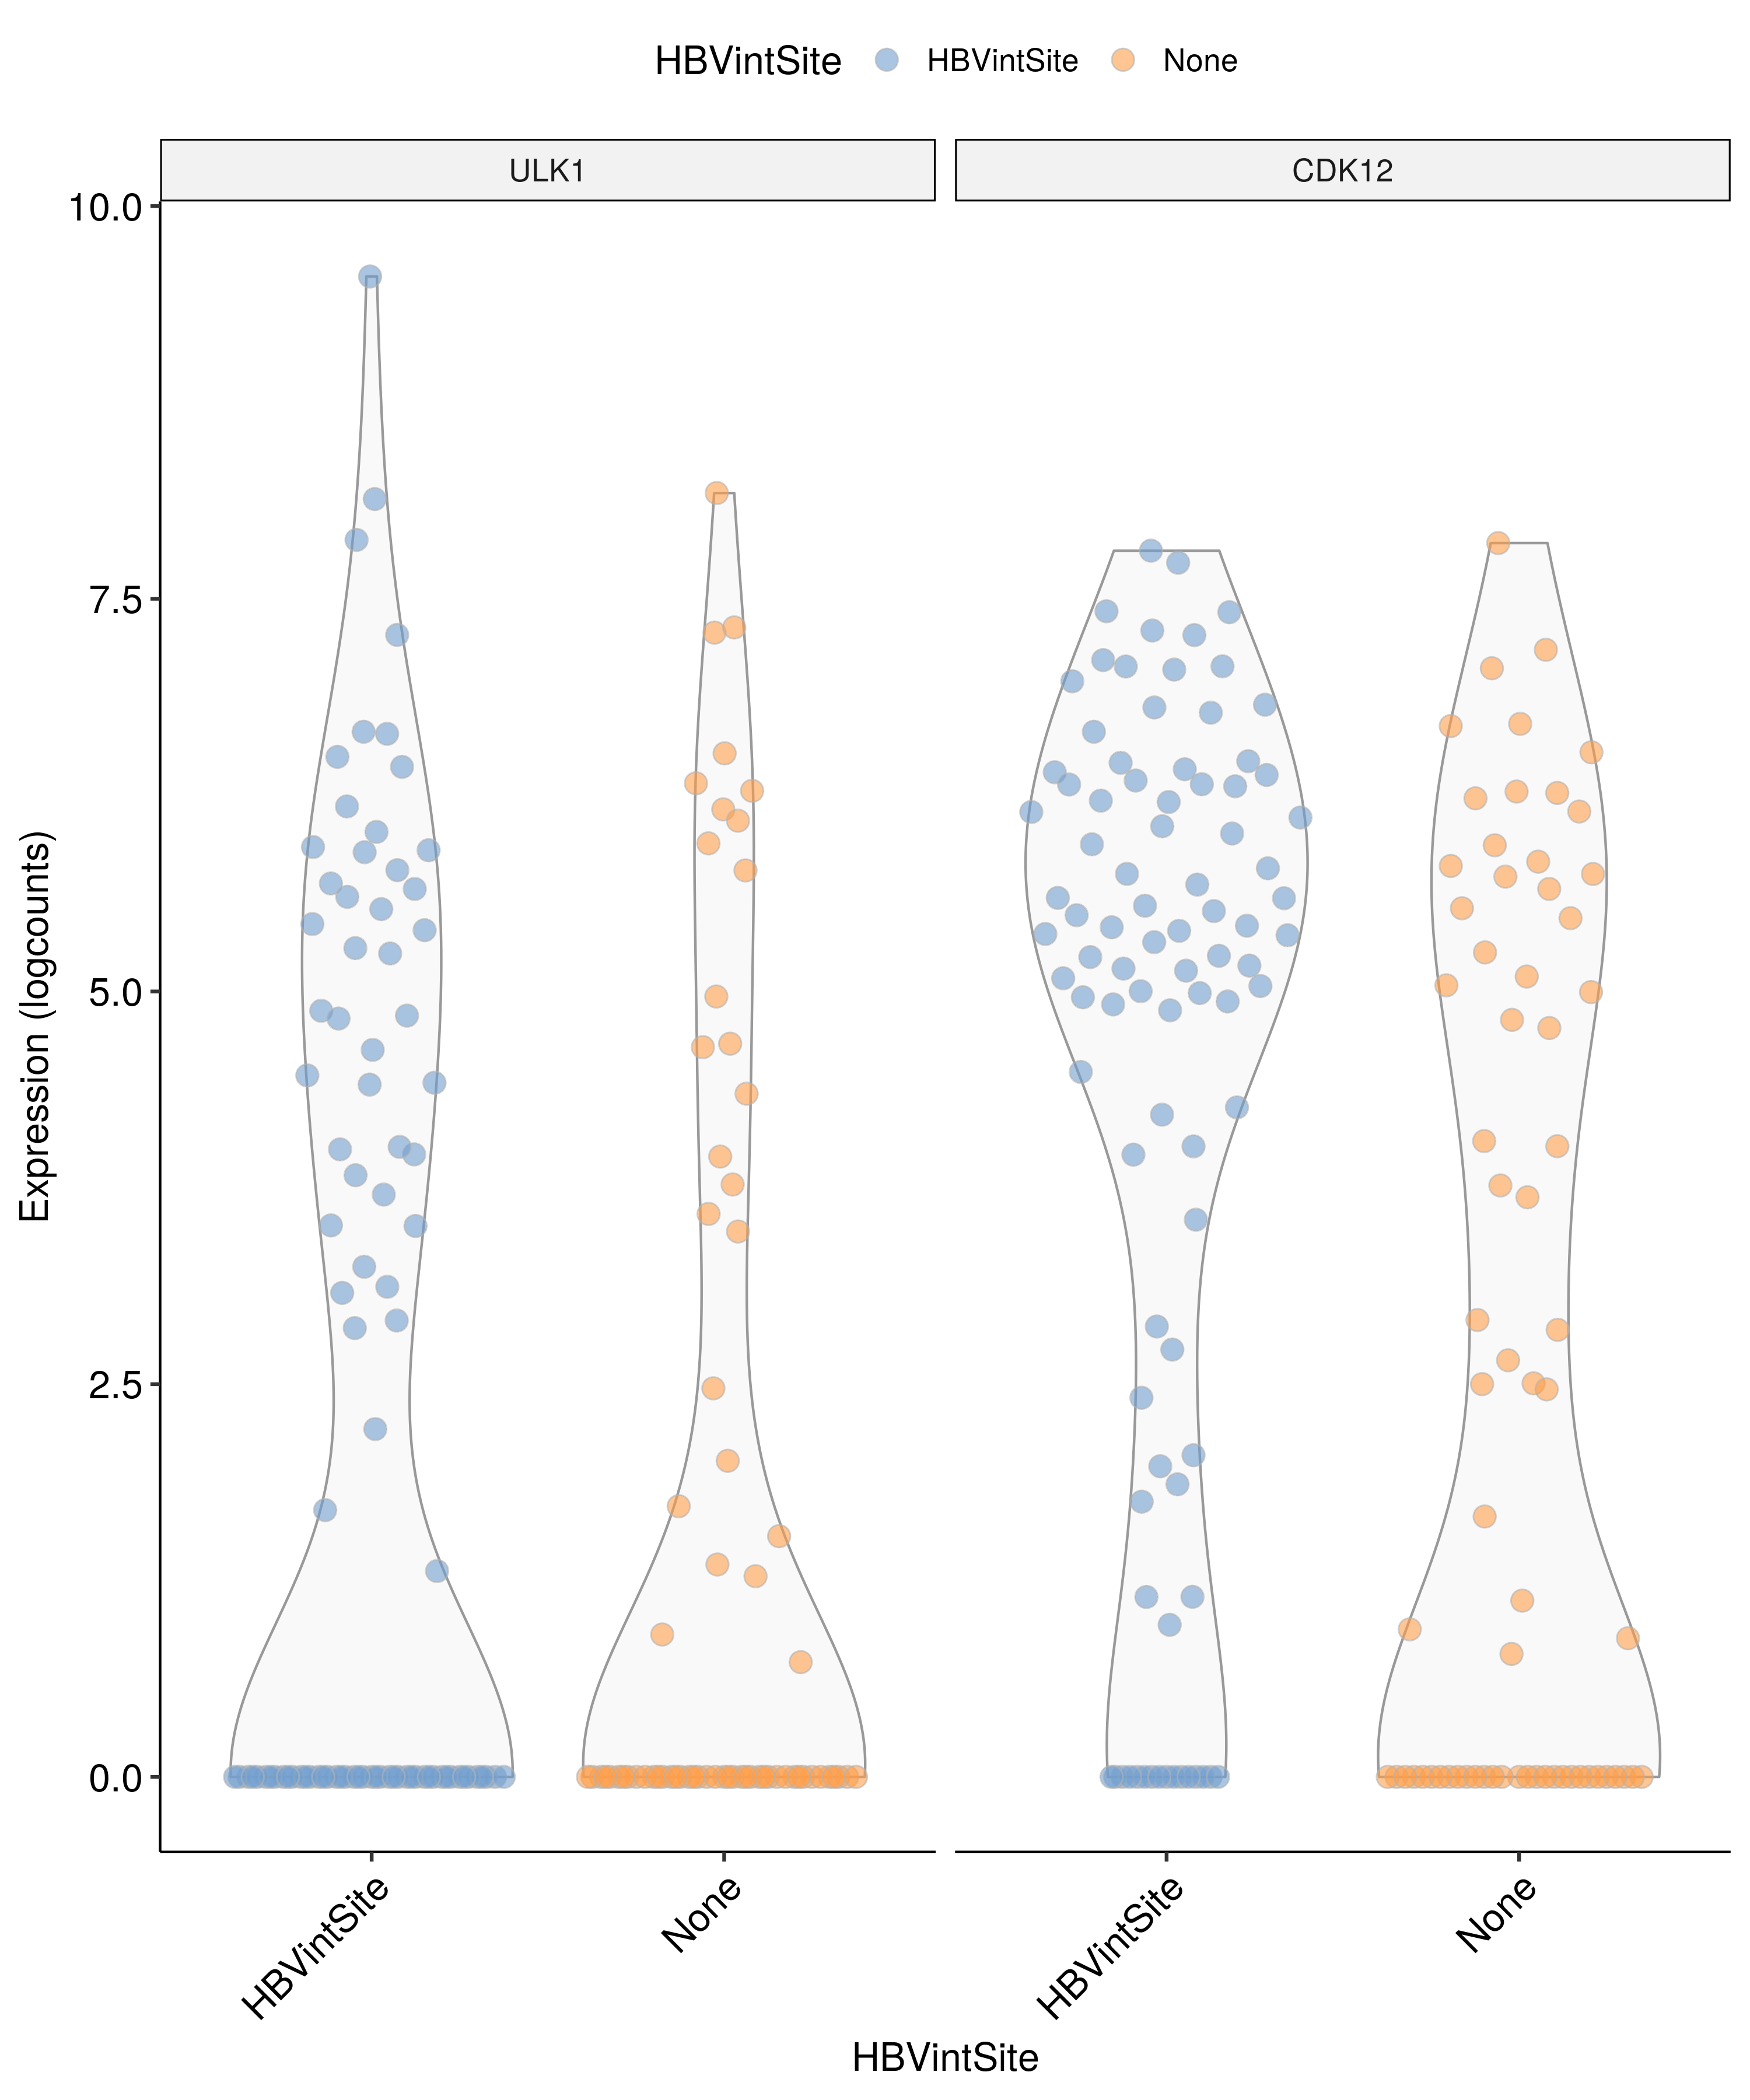

In [99]:
options(repr.plot.width=10, repr.plot.height=12)
plotExpression(sce, features = c("ULK1", "CDK12"), x = "HBVintSite", ncol = 3, colour_by = "HBVintSite", point_size = 4) + 
    ggpubr::theme_pubr(base_size = 16) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

In [67]:
-log10(plotDF$FDR)

[1] 2.376577e+00 1.399005e+00 1.399005e+00 1.399005e+00 1.399005e+00
    [6] 1.380314e+00 1.380314e+00 1.380314e+00 1.380314e+00 1.380314e+00
   [11] 1.380314e+00 1.380314e+00 1.380314e+00 1.380314e+00 1.218790e+00
   [16] 1.218790e+00 1.208650e+00 1.183620e+00 1.153839e+00 1.136287e+00
   [21] 1.114208e+00 1.080431e+00 1.080431e+00 1.080431e+00 1.078536e+00
   [26] 1.071628e+00 1.071628e+00 1.062983e+00 1.062983e+00 1.062983e+00
   [31] 1.062983e+00 1.062983e+00 1.062765e+00 1.062765e+00 1.062765e+00
   [36] 1.062765e+00 1.062765e+00 1.052838e+00 1.047821e+00 1.047821e+00
   [41] 1.047821e+00 1.047821e+00 1.047821e+00 1.024123e+00 1.021656e+00
   [46] 1.018943e+00 1.018943e+00 9.994752e-01 9.994752e-01 9.952182e-01
   [51] 9.952182e-01 9.952182e-01 9.952182e-01 9.813403e-01 9.813403e-01
   [56] 9.813403e-01 9.795583e-01 9.795583e-01 9.735805e-01 9.735805e-01
   [61] 9.735805e-01 9.551708e-01 9.481945e-01 9.401265e-01 9.401265e-01
   [66] 9.248976e-01 9.124169e-01 9.096202e-01 9.037725e-01 9.037725e-01
   [71] 9.037725e-01 9.037725e-01 9.037725e-01 9.037725e-01 9.037725e-01
   [76] 9.037725e-01 9.037725e-01 9.037725e-01 9.037725e-01 9.037725e-01
   [81] 9.037725e-01 9.001197e-01 8.932379e-01 8.911778e-01 8.911778e-01
   [86] 8.886504e-01 8.877729e-01 8.877729e-01 8.877729e-01 8.845643e-01
   [91] 8.788733e-01 8.788733e-01 8.788733e-01 8.788733e-01 8.676919e-01
   [96] 8.634940e-01 8.533119e-01 8.520507e-01 8.520507e-01 8.520507e-01
  [101] 8.520507e-01 8.520507e-01 8.520507e-01 8.520507e-01 8.520507e-01
  [106] 8.491560e-01 8.491560e-01 8.415807e-01 8.406920e-01 8.406920e-01
  [111] 8.373417e-01 8.373417e-01 8.258103e-01 8.204892e-01 8.204892e-01
  [116] 8.204892e-01 8.204892e-01 8.199504e-01 8.181706e-01 8.119112e-01
  [121] 7.745983e-01 7.745983e-01 7.732449e-01 7.732449e-01 7.732449e-01
  [126] 7.732449e-01 7.732449e-01 7.732449e-01 7.732449e-01 7.732449e-01
  [131] 7.732449e-01 7.604746e-01 7.593002e-01 7.570322e-01 7.560226e-01
  [136] 7.484990e-01 7.462780e-01 7.455363e-01 7.455363e-01 7.432672e-01
  [141] 7.424990e-01 7.418628e-01 7.398266e-01 7.374986e-01 7.374986e-01
  [146] 7.374986e-01 7.322976e-01 7.298627e-01 7.293170e-01 7.291146e-01
  [151] 7.231418e-01 7.231418e-01 7.224387e-01 7.209249e-01 7.209249e-01
  [156] 7.209249e-01 7.209249e-01 7.209249e-01 7.209249e-01 7.209249e-01
  [161] 7.209249e-01 7.209249e-01 7.198190e-01 7.198190e-01 7.198190e-01
  [166] 7.198190e-01 7.198190e-01 7.198190e-01 7.198190e-01 7.184448e-01
  [171] 7.184448e-01 7.184448e-01 7.184448e-01 7.184448e-01 7.184448e-01
  [176] 7.184448e-01 7.184448e-01 7.184448e-01 7.139352e-01 7.128935e-01
  [181] 7.062658e-01 7.048617e-01 7.047736e-01 7.022971e-01 6.993159e-01
  [186] 6.940145e-01 6.940145e-01 6.940145e-01 6.940145e-01 6.926686e-01
  [191] 6.921513e-01 6.907265e-01 6.907265e-01 6.907265e-01 6.833046e-01
  [196] 6.833046e-01 6.833046e-01 6.833046e-01 6.833046e-01 6.833046e-01
  [201] 6.833046e-01 6.833046e-01 6.833046e-01 6.833046e-01 6.833046e-01
  [206] 6.833046e-01 6.833046e-01 6.833046e-01 6.833046e-01 6.784516e-01
  [211] 6.784516e-01 6.775730e-01 6.775730e-01 6.775730e-01 6.775730e-01
  [216] 6.775730e-01 6.775730e-01 6.775730e-01 6.775730e-01 6.775730e-01
  [221] 6.749708e-01 6.742279e-01 6.742279e-01 6.742279e-01 6.742279e-01
  [226] 6.741898e-01 6.741898e-01 6.741898e-01 6.707775e-01 6.696072e-01
  [231] 6.678557e-01 6.678557e-01 6.678557e-01 6.653092e-01 6.653092e-01
  [236] 6.653092e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01
  [241] 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01
  [246] 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01
  [251] 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01
  [256] 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01
  [261] 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01
  [266] 6.638714e-01 6.638714e-01 6.638714e-01 6.638714e-01 6.634648e-01
  [271] 6.634648e-01 6.634648e-01 6.629781e-01 6.625967e-01 6.